In [1]:
import requests

from astropy import units as u
import lightkurve as lk
from exovetter import const as exo_const
from exovetter.tce import Tce
from exovetter import vetters as vet
import matplotlib.pyplot as plt
from astroquery.mast import Catalogs
import numpy as np

%load_ext autoreload
%autoreload 2
%matplotlib inline

## Running the vetter on the same known exoplanet as Michelle

## Our version of the TCE

In [2]:
planeturl = "https://exo.mast.stsci.edu/api/v0.1/exoplanets/"
planet_name = "WASP-46 b"
header={} # Optional dictionary of HTTP headers to send to mast.

url = planeturl + planet_name + "/properties/"

r = requests.get(url = url, headers = header) # Returns a requests.Response object from exo.mast

planet_prop = r.json() # Returns a JSON object of the result
planet_prop
nexsci_prop = planet_prop[1]  # Return the one from the nexsci catalog

# Now we can use the Tce function to create a tce object
tce = Tce(period = nexsci_prop['orbital_period'] * u.day,
         epoch = nexsci_prop['transit_time'] * u.day,
         epoch_offset =  -2_400_000.5 * u.day,
         depth = nexsci_prop['transit_depth'] * exo_const.frac_amp,
         duration = nexsci_prop['transit_duration'] * u.day,
         snr = 50, #This value is only used by LPP and doesn't need to be very precise
         event_name = "WASP-46 b",
         target_name = "WASP-46 b")

# We can validate that all required parameters are present with the validate method
print(f"All required parameters present: {tce.validate()}")


All required parameters present: True


In [3]:
# Download all SPOC FFI light curves
tic = 231663901
search_result = lk.search_lightcurve(f"TIC {tic}", mission="TESS", author="TESS-SPOC")
lcs = search_result.download_all()

# Stitch light curves together into a multi-sector light curve
lc = lcs.stitch()

lc = lc.SAP_FLUX.remove_nans().remove_outliers()

lc_flat = lc.flatten(window_length=81)

/var/folders/qd/p48wml6j7313gsggzbjyyj000005fl/T/ipykernel_21482/3910586788.py:9: LightkurveDeprecationWarning: The SAP_FLUX function is deprecated and may be removed in a future version.
  lc = lc.SAP_FLUX.remove_nans().remove_outliers()


{'period': <Quantity 1.43036763 d>,
 'epoch': <Quantity 56842.2141 d>,
 'epoch_offset': <Quantity -2400000.5 d>,
 'depth': <Quantity 0.01967932>,
 'duration': <Quantity 0.0684947 d>,
 'snr': 50,
 'event_name': 'WASP-46 b',
 'target_name': 'WASP-46 b'}

time,flux,flux_err,timecorr,cadenceno,centroid_col,centroid_row,sap_flux,sap_flux_err,sap_bkg,sap_bkg_err,pdcsap_flux,pdcsap_flux_err,quality,psf_centr1,psf_centr1_err,psf_centr2,psf_centr2_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2
,,,d,,pix,pix,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,,pix,pix,pix,pix,pix,pix,pix,pix,pix,pix
Time,float64,float64,float32,int32,float64,float64,float32,float32,float32,float32,float32,float32,int32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32
1325.3489580494802,1.0007050e+00,9.9424918e-04,4.6121906e-03,4698,1849.60736,1518.53888,1.2340039e+03,1.2260430e+00,3.7625027e+02,3.8314438e-01,1.7204354e+03,1.9063081e+00,0,———,———,———,———,1849.60736,4.7434622e-04,1518.53888,4.7798449e-04,-3.6651355e-03,1.0208008e-02
1325.3697912859773,9.9994555e-01,9.9587462e-04,4.6121022e-03,4699,1849.60693,1518.53931,1.2330674e+03,1.2280474e+00,3.8164874e+02,3.8499820e-01,1.7189001e+03,1.9094245e+00,0,———,———,———,———,1849.60693,4.7540548e-04,1518.53931,4.7900656e-04,-2.9917483e-03,1.0379951e-02
1325.3906245215426,1.0023605e+00,1.0009926e-03,4.6120128e-03,4700,1849.60632,1518.54030,1.2360453e+03,1.2343585e+00,3.8884091e+02,3.8767383e-01,1.7231960e+03,1.9192375e+00,0,———,———,———,———,1849.60632,4.7664720e-04,1518.54030,4.8023646e-04,-2.5253396e-03,1.0325528e-02
1325.4114577571083,9.9968026e-01,1.0009948e-03,4.6119234e-03,4701,1849.60673,1518.53968,1.2327402e+03,1.2343613e+00,3.9517987e+02,3.8969690e-01,1.7180607e+03,1.9192418e+00,0,———,———,———,———,1849.60673,4.7805245e-04,1518.53968,4.8133664e-04,-3.4703899e-03,9.1413865e-03
1325.432290991743,1.0002661e+00,1.0014541e-03,4.6118330e-03,4702,1849.60801,1518.53927,1.2334626e+03,1.2349277e+00,3.9888635e+02,3.9063656e-01,1.7191421e+03,1.9201224e+00,0,———,———,———,———,1849.60801,4.7763766e-04,1518.53927,4.8120916e-04,-1.9005135e-03,9.5898136e-03
1325.4531242259125,1.0011186e+00,1.0037139e-03,4.6117422e-03,4703,1849.60771,1518.53949,1.2345139e+03,1.2377143e+00,4.0269522e+02,3.9194652e-01,1.7212830e+03,1.9244550e+00,0,———,———,———,———,1849.60771,4.7811525e-04,1518.53949,4.8184500e-04,-1.5328347e-03,9.7061461e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2060.6055531766415,1.0009953e+00,2.1247866e-03,4.5764837e-03,119972,1238.82380,1413.73333,1.4543925e+03,3.0872011e+00,1.6582976e+03,1.4205964e+00,———,———,1000000000000,———,———,———,———,1238.82380,1.2592931e-03,1413.73333,1.3914959e-03,6.8756742e-03,-6.0949259e-02


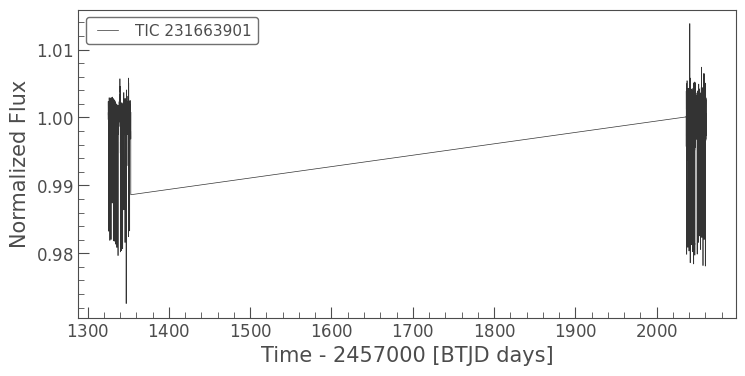

In [4]:
# View the tce and flattened lightcurve we're vetting: 
display(tce)
display(lc_flat)
lc_flat.plot()
plt.show()

## Vetter

In [7]:
# Initialize the single_event object 
leo = vet.LeoVetter(lc_name="flux", flux_err='flux_err', frac=0.7, max_chases_phase = 0.1)

# We then run the vetter on the desired TCE and lightcurve which results in a dictionary of relevent metrics
leo_results = leo.run(tce,lc_flat)


#print("Results from single_event:")
#display(single_event_results)

we make epo here: 1326.0053323099828
alternatively: 2456842.7141 d


In [12]:
print('OUR INPUT:')
print('time: ', leo.time)
print('flux: ', leo.flux)
print('flux_err: ', leo.flux_err)
print('per: ', leo.period)
print('epo: ', leo.epo)
print('dur: ', leo.duration)

OUR INPUT:
time:  [1325.34895805 1325.36979129 1325.39062452 ... 2060.62638643 2060.63333085
 2060.64027527]
flux:  [1.00070502 0.99994555 1.00236046 ... 1.0018263  0.99969216 1.00060158]
flux_err:  [0.00099425 0.00099587 0.00100099 ... 0.0021356  0.00213681 0.00214133]
per:  1.43036763
epo:  1326.0053323099828
dur:  0.0684947


In [14]:
print('OUR RESULTS:')
print('sig_w:', leo.metrics["sig_w"])
print('sig_r:', leo.metrics["sig_r"])
print('err:', leo.metrics["err"])
print('MES:', leo.metrics["MES"])
print('SHP:', leo.metrics["SHP"])
print('CHI:', leo.metrics["CHI"])
print('med_chases:', leo.metrics["med_chases"])
print('mean_chases:', leo.metrics["mean_chases"])
print('max_SES:', leo.metrics["max_SES"])
print('DMM:', leo.metrics["DMM"])


print('MES_series', leo.MES_series)
print('N_transit', leo.N_transit )
print('SES', leo.SES)
print('SES_series', leo.SES_series)
print('chases', leo.chases)
print('dep', leo.dep)
print('dep_series', leo.dep_series)
print('epochs', leo.epochs)
print('err_series', leo.err_series)
print('fit_tran', leo.fit_tran)
print('in_tran', leo.in_tran)
print('n_in', leo.n_in)
print('near_tran', leo.near_tran)
print('phase', leo.phase)
print('qtran', leo.qtran)
print('rubble', leo.rubble)
print('tran_epochs', leo.tran_epochs)
print('zpt', leo.zpt)

OUR RESULTS:
sig_w: 0.0016403372760923096
sig_r: 0.0005200076789826461
err: 0.00014431690568781873
MES: 89.21743457507013
SHP: 0.05112466122092516
CHI: 163.78534250184396
med_chases: 1.0
mean_chases: 1.0
max_SES: 19.30969345740498
DMM: 0.9874468450060117
MES_series [ 1.1525803   0.41742141  0.08879909 ... -0.8614077  -0.7268431
 -0.96029378]
N_transit 34
SES [11.43025271 12.41320016 13.25677657  6.76693476 13.40531881 12.96942291
 11.22212845 13.34412446 13.45725124 15.06910467 13.72565598 12.71366218
  9.09640935 14.30413031 11.59180595 12.29016475 10.48575434  6.60634063
 18.7333624  16.59538898 17.84175852 18.98959706 15.91048143 18.08853902
 19.00452359 19.30969346 16.89967023 16.47905453 15.16012405 17.066227
 16.92726059 18.4299186  16.46924032 17.57771614]
SES_series [-0.26630293 -0.93604741 -0.6221983  ... -1.69365171 -1.72049042
 -1.72344884]
chases [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
dep 0.012875584091279535